In [1]:
import nflfastpy as npy
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_2021 = npy.load_pbp_data(2021)
df_roster_2021 = npy.load_roster_data(2021)

In [75]:
for column in df_2021.columns:
    print(column)

play_id
game_id
old_game_id
home_team
away_team
season_type
week
posteam
posteam_type
defteam
side_of_field
yardline_100
game_date
quarter_seconds_remaining
half_seconds_remaining
game_seconds_remaining
game_half
quarter_end
drive
sp
qtr
down
goal_to_go
time
yrdln
ydstogo
ydsnet
desc
play_type
yards_gained
shotgun
no_huddle
qb_dropback
qb_kneel
qb_spike
qb_scramble
pass_length
pass_location
air_yards
yards_after_catch
run_location
run_gap
field_goal_result
kick_distance
extra_point_result
two_point_conv_result
home_timeouts_remaining
away_timeouts_remaining
timeout
timeout_team
td_team
td_player_name
td_player_id
posteam_timeouts_remaining
defteam_timeouts_remaining
total_home_score
total_away_score
posteam_score
defteam_score
score_differential
posteam_score_post
defteam_score_post
score_differential_post
no_score_prob
opp_fg_prob
opp_safety_prob
opp_td_prob
fg_prob
safety_prob
td_prob
extra_point_prob
two_point_conversion_prob
ep
epa
total_home_epa
total_away_epa
total_home_rush_epa


In [92]:
# Get plays at the end of 2nd and 3rd quarters
df_3q_pts = (
    df_2021[df_2021["desc"].isin(["END QUARTER 2", "END QUARTER 3"])].copy()
)

# Combine 2nd and 3rd quarter scores into one row for each game
df_3q_pts = (
    df_3q_pts.groupby(["game_id", "home_team", "away_team"], as_index=False)
    .agg(
        home_score_half=("total_home_score", "min"),
        away_score_half=("total_away_score", "min"),
        home_score_third=("total_home_score", "max"),
        away_score_third=("total_away_score", "max"),
    )
)

# Calculations for net points
df_3q_pts["net_half"] = df_3q_pts["home_score_half"] - df_3q_pts["away_score_half"]
df_3q_pts["net_third"] = df_3q_pts["home_score_third"] - df_3q_pts["away_score_third"]
df_3q_pts["net"] = df_3q_pts["net_third"] - df_3q_pts["net_half"]

# Get the net 3rd quarter points for unique home and away teams
df_agg_home = df_3q_pts.groupby("home_team", as_index=False).agg(pts_diff_home=("net", "sum"))
df_agg_away = df_3q_pts.groupby("away_team", as_index=False).agg(pts_diff_away=("net", "sum"))

# Merge home and away team data to get net for each team
df_3q_pts = df_agg_home.merge(df_agg_away, left_on="home_team", right_on="away_team")
df_3q_pts["pts_diff"] = df_3q_pts["pts_diff_home"] - df_3q_pts["pts_diff_away"]
df_3q_pts = df_3q_pts.rename(columns={"home_team": "team"})[["team", "pts_diff"]].sort_values("pts_diff", ascending=False).reset_index(drop=True).copy()

In [93]:
df_3q_pts

,team,pts_diff
0,BUF,69
1,GB,64
2,IND,59
3,CIN,49
4,KC,44
5,DAL,43
6,LA,42
7,LV,42
8,PHI,32
9,ARI,21


In [85]:
# Filter to all passing plays in the 3rd quarter
df_3q_pass = (
    df_2021[df_2021["qtr"] == 3].dropna(subset=["passer_player_id"]).copy()
)

# Merge with roster data to get full name of QB
df_3q_pass = df_3q_pass.merge(df_roster_2021[["full_name", "gsis_id"]], left_on="passer_player_id", right_on="gsis_id").copy()

# Aggregate passing metrics from play-by-play data
df_3q_pass = (
    df_3q_pass.groupby(["full_name"], as_index=False)
    .agg(
        completions=("complete_pass", "sum"),
        attempts=("pass_attempt", "sum"),
        yds=("passing_yards", "sum"),
        tds=("pass_touchdown", "sum"),
        ints=("interception", "sum")
    )
)

# Function to calculate passer rating
def passer_rating(row):
    a = ((row["completions"] / row["attempts"]) - 0.3) * 5
    b = ((row["yds"] / row["attempts"]) - 3) * 0.25
    c = (row["tds"] / row["attempts"]) * 20
    d = 2.375 - ((row["ints"] / row["attempts"]) * 25)
    
    a = min(max(a, 0), 2.375)
    b = min(max(b, 0), 2.375)
    c = min(max(c, 0), 2.375)
    d = min(max(d, 0), 2.375)
    
    return round(((a + b + c + d) / 6) * 100, 1)

# Calculate passer rating on aggregated data
df_3q_pass["passer_rating"] = df_3q_pass.apply(passer_rating, axis=1)

# Filter to QBs with at least 25 completions and sort by descending passer rating
df_3q_pass = df_3q_pass[df_3q_pass["completions"] >= 25].sort_values("passer_rating", ascending=False).reset_index(drop=True).copy()

In [86]:
df_3q_pass

,full_name,completions,attempts,yds,tds,ints,passer_rating
0,Matthew Stafford,80.0,128.0,1242.0,10.0,1.0,117.4
1,Joe Burrow,73.0,110.0,1069.0,7.0,2.0,111.5
2,Aaron Rodgers,80.0,116.0,879.0,10.0,3.0,109.1
3,Jimmy Garoppolo,60.0,91.0,785.0,5.0,1.0,106.7
4,Lamar Jackson,61.0,101.0,783.0,6.0,0.0,104.5
5,Dak Prescott,70.0,105.0,709.0,7.0,1.0,104.0
6,Derek Carr,87.0,125.0,1029.0,7.0,3.0,103.0
7,Tom Brady,89.0,134.0,892.0,7.0,0.0,102.6
8,Tua Tagovailoa,37.0,59.0,416.0,3.0,1.0,93.6
9,Daniel Jones,60.0,84.0,602.0,3.0,2.0,93.5


In [117]:
# Filter to rushing plays in the 3rd quarter
df_3q_rush = (
    df_2021[df_2021["qtr"] == 3].dropna(subset=["rusher_player_id"]).copy()
)

# Merge with roster data to get full name of RB
df_3q_rush = df_3q_rush.merge(df_roster_2021[["full_name", "gsis_id"]], left_on="rusher_player_id", right_on="gsis_id").copy()

# Aggregate rushing data and sort by descending rushing yards
df_3q_rush = (
    df_3q_rush.groupby(["full_name"], as_index=False)
    .agg(
        attempts=("rush_attempt", "sum"),
        yds=("rushing_yards", "sum"),
        tds=("rush_touchdown", "sum")
    )
    .sort_values("yds", ascending=False).reset_index(drop=True)
)

In [118]:
df_3q_rush

,full_name,attempts,yds,tds
0,Jonathan Taylor,66.0,506.0,7.0
1,Joe Mixon,78.0,384.0,3.0
2,Nick Chubb,45.0,338.0,3.0
3,Antonio Gibson,66.0,299.0,1.0
4,James Robinson,47.0,277.0,2.0
...,...,...,...,...
228,Evan Engram,1.0,-3.0,0.0
229,Anthony Schwartz,1.0,-3.0,0.0
230,Dyami Brown,1.0,-4.0,0.0
231,Sterling Shepard,1.0,-9.0,0.0


In [124]:
# Filter to receiving plays in the 3rd quarter
df_3q_rec = (
    df_2021[df_2021["qtr"] == 3].dropna(subset=["receiver_player_id"]).copy()
)

# Merge with roster data to get full name of RB
df_3q_rec = df_3q_rec.merge(df_roster_2021[["full_name", "gsis_id"]], left_on="receiver_player_id", right_on="gsis_id").copy()

# Aggregate rushing data and sort by descending rushing yards
df_3q_rec = (
    df_3q_rec.groupby(["full_name"], as_index=False)
    .agg(
        targets=("pass_attempt", "sum"),
        catches=("complete_pass", "sum"),
        yds=("receiving_yards", "sum"),
        tds=("pass_touchdown", "sum")
    )
    .sort_values("yds", ascending=False).reset_index(drop=True)
)

In [125]:
df_3q_rec

,full_name,targets,catches,yds,tds
0,Deebo Samuel,28.0,20.0,466.0,2.0
1,Cooper Kupp,42.0,29.0,465.0,6.0
2,Ja'Marr Chase,25.0,20.0,406.0,2.0
3,Tyreek Hill,37.0,27.0,343.0,1.0
4,Travis Kelce,36.0,25.0,324.0,2.0
...,...,...,...,...,...
401,Juwan Johnson,1.0,0.0,0.0,0.0
402,JuJu Smith-Schuster,5.0,0.0,0.0,0.0
403,Godwin Igwebuike,2.0,0.0,0.0,0.0
404,Taylor Decker,1.0,1.0,-2.0,0.0


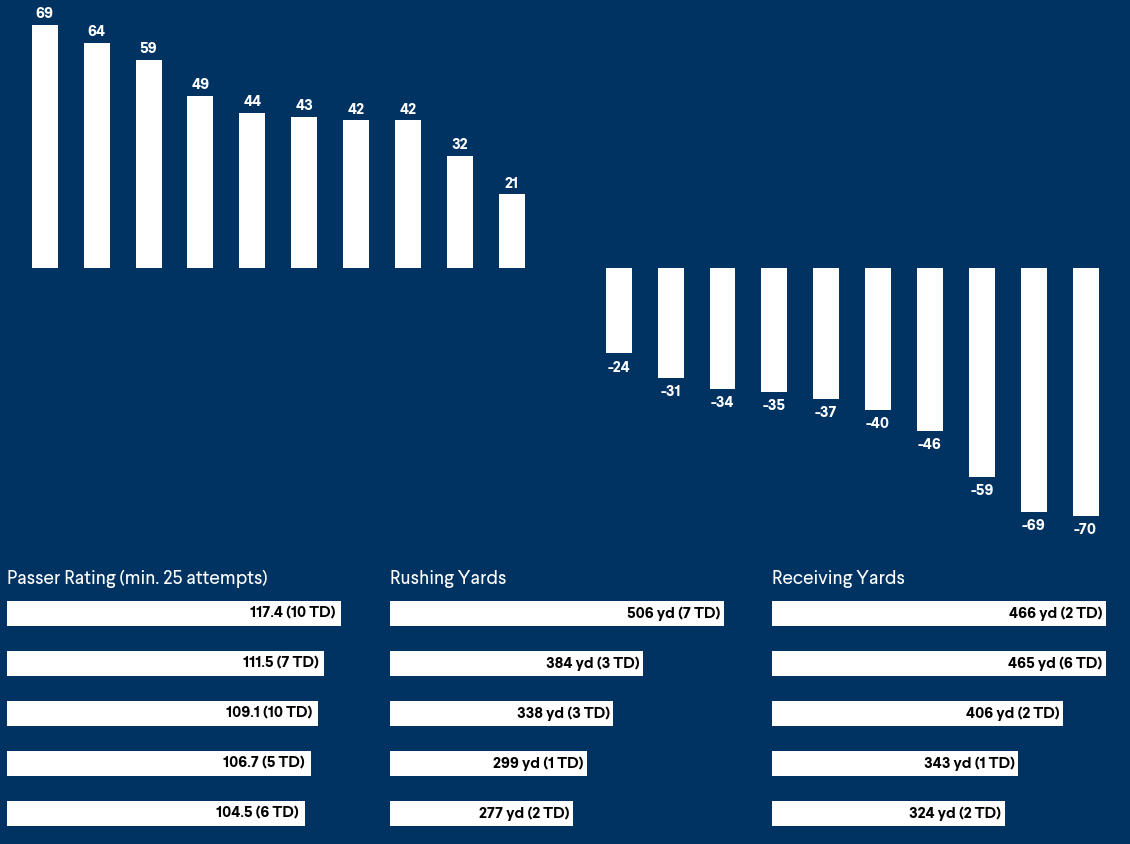

In [156]:
plt.rcParams["font.family"] = "Larsseit"
plt.rcParams["font.size"] = 16

fig = plt.figure(figsize=(20, 15), facecolor="#003262")
gs = fig.add_gridspec(nrows=2, ncols=6, height_ratios=[2, 1])

ax_pts_top = fig.add_subplot(gs[0, :3], frame_on=False)
ax_pts_bottom = fig.add_subplot(gs[0, 3:], frame_on=False)
ax_pass = fig.add_subplot(gs[1, :2], frame_on=False)
ax_rush = fig.add_subplot(gs[1, 2:4], frame_on=False)
ax_rec = fig.add_subplot(gs[1, 4:], frame_on=False)

# Point Differential
ax_pts_top.bar(range(10), df_3q_pts.head(10)["pts_diff"], width=0.5, color="w")
ax_pts_bottom.bar(range(10), df_3q_pts.tail(10)["pts_diff"], width=0.5, color="w")

# Add bar annotations
for i, val in enumerate(df_3q_pts.head(10)["pts_diff"]):
    ax_pts_top.text(i, val + 2, val, ha="center", va="baseline", fontweight=600, color="w")
    
for i, val in enumerate(df_3q_pts.tail(10)["pts_diff"]):
    ax_pts_bottom.text(i, val - 2, val, ha="center", va="top", fontweight=600, color="w")
    
# Top Passers
ax_pass.barh(range(5), df_3q_pass.head(5)["passer_rating"], height=0.5, color="w")
ax_pass.invert_yaxis()

for i, val in enumerate(df_3q_pass.head(5)["passer_rating"]):
    ax_pass.text(val - 2, i, f"{val} ({int(df_3q_pass.iloc[i].tds)} TD)", ha="right", va="center", fontweight=600)
    
ax_pass.set_title("Passer Rating (min. 25 attempts)", loc="left", color="w")

    
# Top Rushers
ax_rush.barh(range(5), df_3q_rush.head(5)["yds"], height=0.5, color="w")
ax_rush.invert_yaxis()

for i, val in enumerate(df_3q_rush.head(5)["yds"]):
    ax_rush.text(val - 5, i, f"{int(val)} yd ({int(df_3q_rush.iloc[i].tds)} TD)", ha="right", va="center", fontweight=600)
    
ax_rush.set_title("Rushing Yards", loc="left", color="w")

# Top Receivers
ax_rec.barh(range(5), df_3q_rec.head(5)["yds"], height=0.5, color="w")
ax_rec.invert_yaxis()

for i, val in enumerate(df_3q_rec.head(5)["yds"]):
    ax_rec.text(val - 5, i, f"{int(val)} yd ({int(df_3q_rec.iloc[i].tds)} TD)", ha="right", va="center", fontweight=600)
    
ax_rec.set_title("Receiving Yards", loc="left", color="w")

ax_pts_top.set(xticks=[], yticks=[], ylim=[-70, 70])
ax_pts_bottom.set(xticks=[], yticks=[], ylim=[-70, 70])
ax_pass.set(xticks=[], yticks=[])
ax_rush.set(xticks=[], yticks=[])
ax_rec.set(xticks=[], yticks=[])

plt.show()